In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


Mounting gdrive to save data from Kaggle.

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/gdrive/MyDrive/SoundUrban8K"

Setting Kaggle configuration directory path to folder containing kaggle.json file

In [ ]:
%cd /gdrive/MyDrive/SoundUrban8K

/gdrive/MyDrive/SoundUrban8K


In [ ]:
!pip install -U -q kaggle

By default kaggle is not installed in Colab. Installing kaggle.

In [ ]:
!kaggle --help

usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,config} ...

optional arguments:
  -h, --help            show this help message and exit
  -v, --version         show program's version number and exit

commands:
  {competitions,c,datasets,d,kernels,k,config}
                        Use one of:
                        competitions {list, files, download, submit, submissions, leaderboard}
                        datasets {list, files, download, create, version, init, metadata, status}
                        config {view, set, unset}
    competitions        Commands related to Kaggle competitions
    datasets            Commands related to Kaggle datasets
    kernels             Commands related to Kaggle kernels
    config              Configuration settings


Importing data from Kaggle to Gdrive

In [ ]:
#Kaggle API command
#!kaggle datasets download -d chrisfilo/urbansound8k

In [ ]:
%ls

features.csv  fold10/  fold4/  fold7/  kaggle.json
features.npy  fold2/   fold5/  fold8/  UrbanSound8K.csv
fold1/        fold3/   fold6/  fold9/  UrbanSound8K.ipynb


Unzipping and removing all files that have the extension ".zip"

In [ ]:
#unzipping the zip files and deleting the zip files
#!unzip \*.zip  && rm *.zip

*Loading sound and visualizing using Librosa*

In [ ]:
import librosa
import matplotlib.pyplot as plt
data, sr = librosa.load('/gdrive/MyDrive/SoundClassification/fold4/107653-9-0-3.wav', None)
print(data.shape)
print('Sampling Rate: {}'.format(sr))

(176400,)
Sampling Rate: 44100


Default sampling rate: 44100

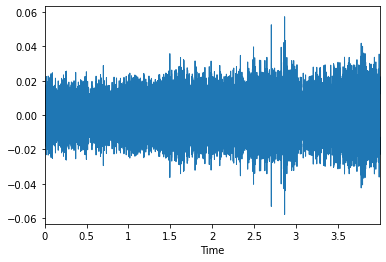

In [ ]:
import librosa.display
librosa.display.waveplot(data, sr=sr);

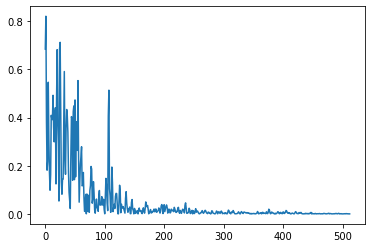

In [ ]:
import numpy as np

n_fft = 1024
D = np.abs(librosa.stft(data[:n_fft], n_fft=n_fft, hop_length=n_fft+1))
plt.plot(D);
#Fourier Transform

Plotting Mel-Spectogram

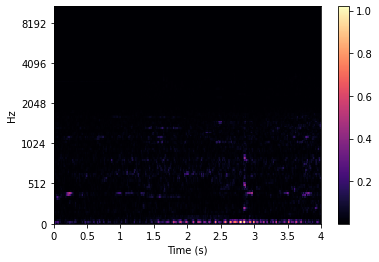

In [ ]:
import matplotlib.pyplot as plt
spec = librosa.feature.melspectrogram(y=data, sr=sr)
import librosa.display
librosa.display.specshow(spec,y_axis='mel', x_axis='s', sr=sr)
plt.colorbar()

We will have to square the amplitude to see more information

Amplitude Squared

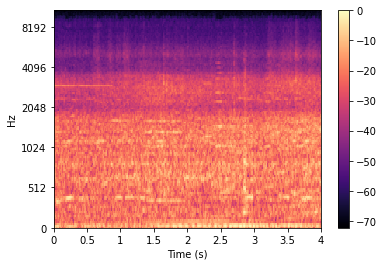

In [ ]:
import numpy as np
db_spec = librosa.power_to_db(spec, ref=np.max,)
librosa.display.specshow(db_spec,y_axis='mel', x_axis='s', sr=sr)
plt.colorbar();

We can see more information now

In [ ]:
print(data)
print(data.shape)
print(sr)

[-0.0032959  -0.00205994 -0.00074768 ...  0.00485229  0.00643921
  0.00804138]
(176400,)
44100


librosa prints data after normalizing between 0 and 1.

sampling rate = 44100; Time = 4s

> 


44100 * 4 = 176400

In [ ]:
from scipy.io import wavfile as wav
audio_file = '/gdrive/MyDrive/SoundClassification/fold4/107653-9-0-3.wav'
wave_sample_rate, wave_audio = wav.read(audio_file)

In [ ]:
wave_audio

array([[-152,  -64],
       [-214,   79],
       [-280,  231],
       ...,
       [ 445, -127],
       [ 462,  -40],
       [ 471,   56]], dtype=int16)

Scipy reads .wav format without normalization.

Librosa takes the average of stereo sound and produces a mono output, but scipy can output stereo sound (dual channel)

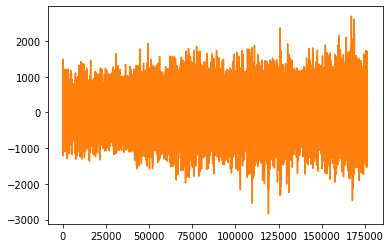

In [ ]:
%matplotlib inline
plt.plot(wave_audio)

2 channels are visible now.

In [ ]:
import pandas as pd
df = pd.read_csv("/gdrive/MyDrive/SoundClassification/UrbanSound8K.csv")
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [ ]:
df['class'].value_counts()

drilling            1000
dog_bark            1000
air_conditioner     1000
engine_idling       1000
children_playing    1000
jackhammer          1000
street_music        1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

It does not look very imbalanced.

In [ ]:
dt2, sr = librosa.load('/gdrive/MyDrive/SoundClassification/fold7/101848-9-0-8.wav', None)
mfccs = librosa.feature.mfcc(y = dt2, sr = sr, n_mfcc = 40)
print(mfccs.shape)

(40, 345)


[MFCC features represent phonemes (distinct units of sound) as the shape of the vocal tract (which is responsible for sound generation) is manifest in them.](https://medium.com/prathena/the-dummys-guide-to-mfcc-aceab2450fd)

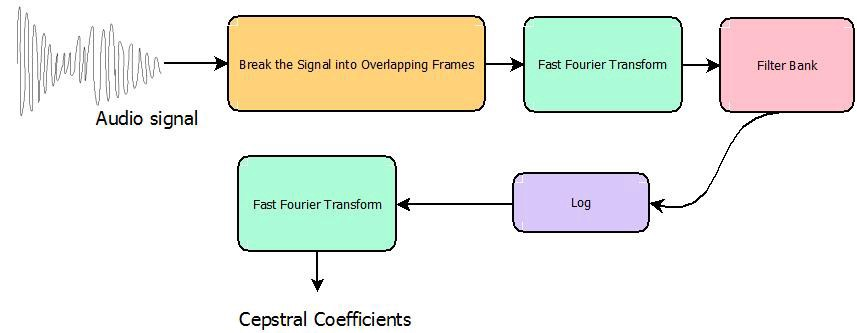

In [ ]:
mfccs.T
print(mfccs.T.shape)

(345, 40)


The above "mfccs" represents the features for one sound. Let us now find and save the MFCCs for all the 8732 sounds.

In [ ]:
def feature_extract(file_name):
  audio , sr = librosa.load(file_name, res_type = 'kaiser_fast')
  mfccs_features = librosa.feature.mfcc(y = audio, sr = sr, n_mfcc = 40)
  #Scaling the features
  mfccs_scaled_features = np.mean(mfccs.T, axis = 0)
  return mfccs_scaled_features

Creating function to iterate through all the files. TQDM for a visual loader.

In [ ]:
from tqdm import tqdm
feature = []
label = []

def parser(row):
    # Function to load files and extract features
    for i in tqdm(range(8732)):
        file_name = '/gdrive/MyDrive/SoundClassification/fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
        # Here kaiser_fast is a technique used for faster extraction
        X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        # We extract mfcc feature from data
        mels = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)        
        feature.append(mels)
        label.append(df["classID"][i])
    return [feature, label]

In [ ]:
temp = parser(df)

  0%|          | 22/8732 [00:35<3:38:55,  1.51s/it]

In [ ]:
temp = np.array(temp)
data = temp.transpose()

X_ = data[:, 0]
Y = data[:, 1]

print(X_.shape, Y.shape)
X = np.empty([8732, 128])

for i in range(8732):
    X[i] = (X_[i])

(8732,) (8732,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical 

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [ ]:
Y = to_categorical(Y)
print(X.shape)
print(Y.shape)

(8732, 128)
(8732, 10)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 1)
X_train = X_train.reshape(6549, 16, 8, 1)
X_test = X_test.reshape(2183, 16, 8, 1)
input_dim = (16, 8, 1)

In [ ]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding = "same", activation = "relu", input_shape = input_dim))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding = "same", activation = "relu"))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(1024, activation = "relu"))
model.add(Dense(10, activation = "softmax"))

In [ ]:
checkpoint_filepath = '/gdrive/MyDrive/SoundClassification/weights.{epoch:02d}-{val_loss:.2f}.h5'

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.fit(X_train, Y_train, epochs = 100, batch_size = 50, validation_data = (X_test, Y_test))

Epoch 1/90
131/131 [==============================] - 33s 6ms/step - loss: 1.7615 - accuracy: 0.4073 - val_loss: 1.3270 - val_accuracy: 0.5570
Epoch 2/90
131/131 [==============================] - 1s 4ms/step - loss: 1.2102 - accuracy: 0.5871 - val_loss: 1.1727 - val_accuracy: 0.6180
Epoch 3/90
131/131 [==============================] - 1s 4ms/step - loss: 0.9890 - accuracy: 0.6674 - val_loss: 1.0565 - val_accuracy: 0.6596
Epoch 4/90
131/131 [==============================] - 1s 4ms/step - loss: 0.8443 - accuracy: 0.7276 - val_loss: 1.0095 - val_accuracy: 0.6908
Epoch 5/90
131/131 [==============================] - 1s 4ms/step - loss: 0.7590 - accuracy: 0.7460 - val_loss: 0.9387 - val_accuracy: 0.6967
Epoch 6/90
131/131 [==============================] - 1s 4ms/step - loss: 0.6852 - accuracy: 0.7743 - val_loss: 0.9191 - val_accuracy: 0.7206
Epoch 7/90
131/131 [==============================] - 1s 4ms/step - loss: 0.6206 - accuracy: 0.7918 - val_loss: 0.8462 - val_accuracy: 0.7545
Epoch

In [ ]:
predictions = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print(score)

69/69 [==============================] - 0s 2ms/step - loss: 0.8086 - accuracy: 0.8672
[0.8086028695106506, 0.8671553134918213]


Spectogram Image Approach